<a href="https://colab.research.google.com/github/muskanalirizvi/-Internboot/blob/main/Task%201%20INTERMEDIATE%20LEVEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile

with zipfile.ZipFile("train.csv (1).zip", "r") as z:
    z.extractall("train_data")


In [ ]:
import pandas as pd

df = pd.read_csv("train_data/train.csv")
df.head()


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [ ]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Group daily total sales (store + family combined)
daily_sales = df.groupby('date')['sales'].sum().reset_index()
daily_sales.head()

,date,sales
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229


In [ ]:
# ============================
# 2. Extract Date Features
# ============================

# Extract basic time features
daily_sales['day'] = daily_sales['date'].dt.day
daily_sales['month'] = daily_sales['date'].dt.month
daily_sales['year'] = daily_sales['date'].dt.year
daily_sales['weekday'] = daily_sales['date'].dt.weekday   # 0 = Monday
daily_sales['weekday_name'] = daily_sales['date'].dt.day_name()

daily_sales.head()


,date,sales,day,month,year,weekday,weekday_name
0,2013-01-01,2511.618999,1,1,2013,1,Tuesday
1,2013-01-02,496092.417944,2,1,2013,2,Wednesday
2,2013-01-03,361461.231124,3,1,2013,3,Thursday
3,2013-01-04,354459.677093,4,1,2013,4,Friday
4,2013-01-05,477350.121229,5,1,2013,5,Saturday


In [ ]:
# ============================
# 3. Create Weekend Flag
# ============================

# 5 = Saturday, 6 = Sunday
daily_sales['is_weekend'] = daily_sales['weekday'].isin([5, 6]).astype(int)

daily_sales[['date', 'weekday_name', 'is_weekend']].head()


,date,weekday_name,is_weekend
0,2013-01-01,Tuesday,0
1,2013-01-02,Wednesday,0
2,2013-01-03,Thursday,0
3,2013-01-04,Friday,0
4,2013-01-05,Saturday,1


In [ ]:
holiday = pd.read_csv("/content/holidays_events.csv")
holiday.head()


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [ ]:
# Convert date to datetime
holiday['date'] = pd.to_datetime(holiday['date'])

# Keep only national holidays
holiday_clean = holiday[holiday['type'] == 'Holiday'][['date', 'locale', 'locale_name']]
holiday_clean.head()


,date,locale,locale_name
0,2012-03-02,Local,Manta
1,2012-04-01,Regional,Cotopaxi
2,2012-04-12,Local,Cuenca
3,2012-04-14,Local,Libertad
4,2012-04-21,Local,Riobamba


In [ ]:
# Merge daily sales with holiday data
daily_sales = daily_sales.merge(holiday_clean, on='date', how='left')


In [ ]:
# If a holiday exists → mark 1 else 0
daily_sales['is_holiday'] = daily_sales['locale'].notna().astype(int)

daily_sales[['date', 'is_holiday']].head()


,date,is_holiday
0,2013-01-01,1
1,2013-01-02,0
2,2013-01-03,0
3,2013-01-04,0
4,2013-01-05,0


In [ ]:
daily_sales = daily_sales.drop(columns=['locale', 'locale_name'])


In [ ]:
# Lag 1 day
daily_sales['lag_1'] = daily_sales['sales'].shift(1)

# Lag 7 days (previous week)
daily_sales['lag_7'] = daily_sales['sales'].shift(7)

# Lag 30 days (previous month)
daily_sales['lag_30'] = daily_sales['sales'].shift(30)

# Drop rows with NaN (first 30 rows will be NaN for lag_30)
daily_sales = daily_sales.dropna().reset_index(drop=True)


In [ ]:
# ============================
# 1. Select Features and Target
# ============================

# Features: numeric + flags + lag features
features = ['day', 'month', 'year', 'weekday', 'is_weekend', 'is_holiday', 'lag_1', 'lag_7', 'lag_30']
X = daily_sales[features]
y = daily_sales['sales']


In [ ]:
# ============================
# 2. Train/Test Split
# ============================
from sklearn.model_selection import train_test_split

# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [ ]:
# ============================
# 3. Train Linear Regression Model
# ============================
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [ ]:
# ============================
# 4. Make Predictions
# ============================
y_pred = model.predict(X_test)


In [ ]:
# ============================
# 5. Evaluate Model
# ============================
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)


Mean Squared Error (MSE): 17816393077.616352
R² Score: 0.4813933659718518


these are before results : Mean Squared Error: 980769.1710860183 R-squared (R2): 0.18015141589800443

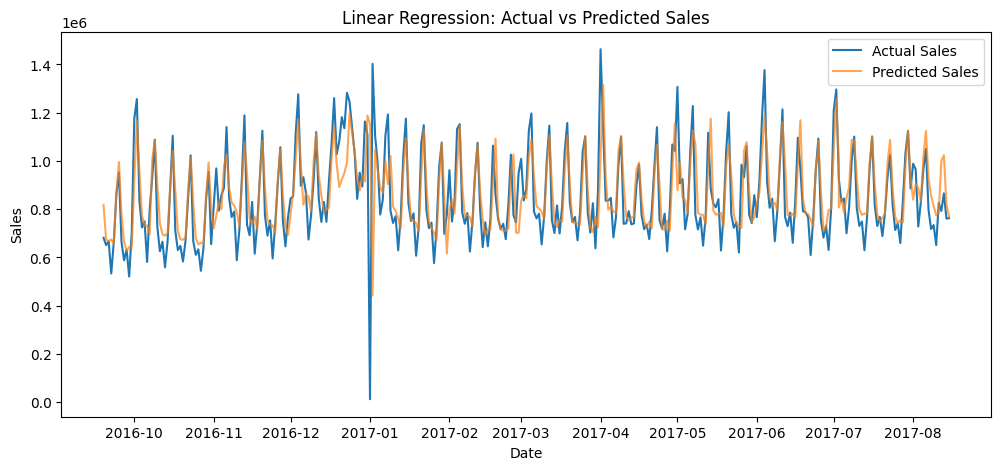

In [ ]:
# ============================
# 6. Plot Actual vs Predicted
# ============================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(daily_sales['date'].iloc[-len(y_test):], y_test, label='Actual Sales')
plt.plot(daily_sales['date'].iloc[-len(y_test):], y_pred, label='Predicted Sales', alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Linear Regression: Actual vs Predicted Sales")
plt.legend()
plt.show()
